In [1]:
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing & metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats

#Model
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## Exploratory Data Analysis

In [2]:
df=pd.read_csv('column_2C_weka.csv')
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [3]:
df.columns

Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')

In [4]:
df.rename(columns=lambda x : str(x).replace(" ","_"), inplace=True)

In [5]:
df.shape

(310, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt_numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [7]:
df.describe()

,pelvic_incidence,pelvic_tilt_numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


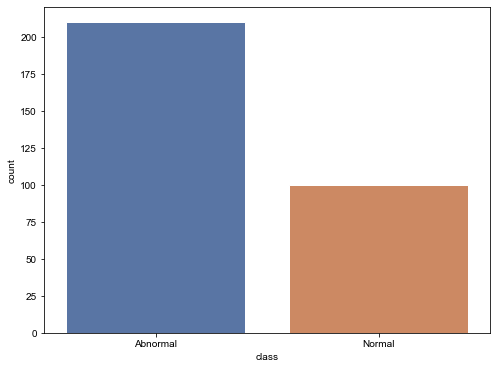

In [8]:
fig, axs = plt.subplots(figsize=[8, 6])
sns.set(style="whitegrid")

sns.countplot(x="class",
              data=df,
              order = df['class'].value_counts().index,
              )
plt.show()

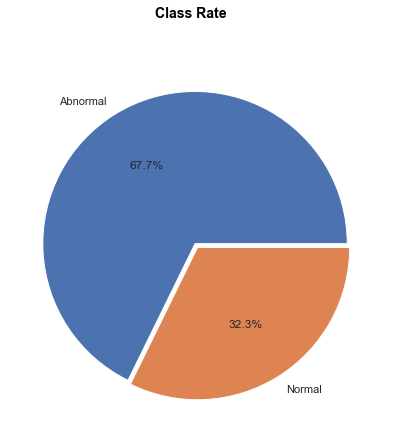

In [9]:
labels=df['class'].value_counts().index
values=df['class'].value_counts().values
explode = (0.03, 0)
#visualization
plt.figure(figsize=(7,7))
plt.pie(values,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%')
plt.suptitle('Class Rate',
          color='black',
          fontsize=14,
          fontweight='bold')
plt.show()

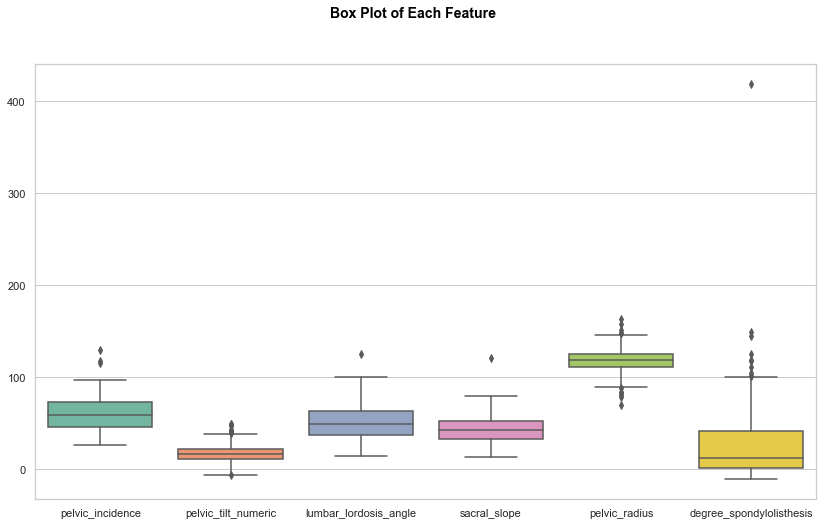

In [10]:
fig, axs = plt.subplots(figsize=[14, 8], ncols=1)

ax = sns.boxplot(data=df.iloc[:,:-1], 
                 orient="v", 
                 palette="Set2")
plt.suptitle('Box Plot of Each Feature',
          color='black',
          fontsize=14,
          fontweight='bold')
plt.show()

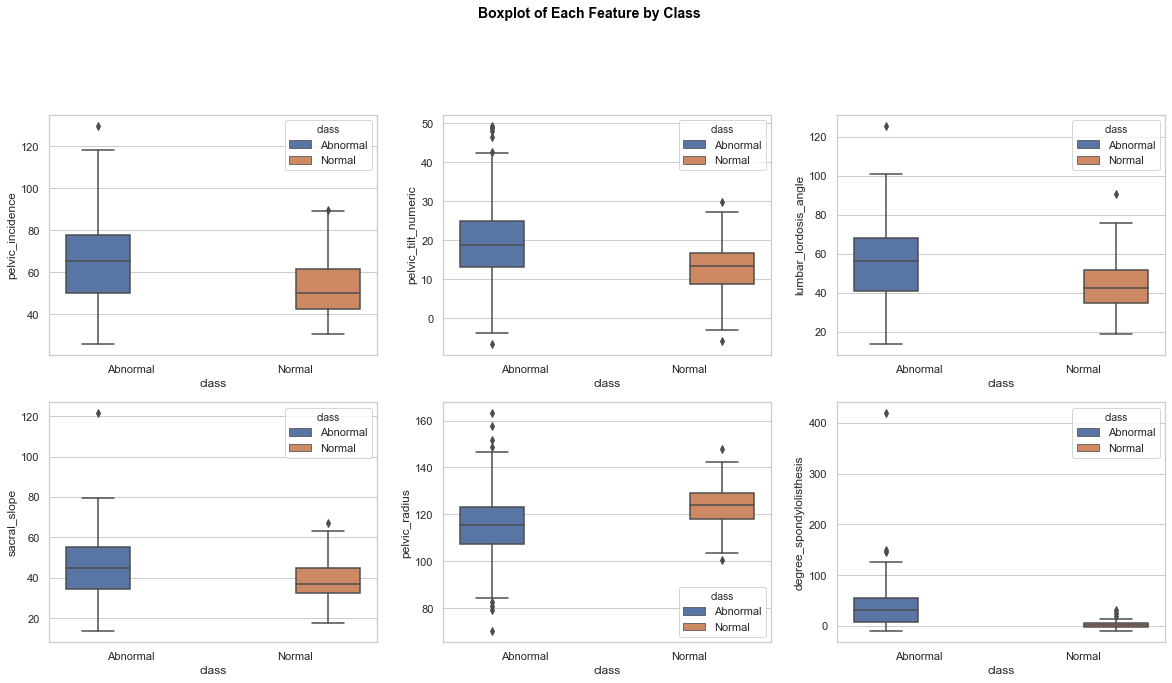

In [11]:
columns=df.columns
k=1

plt.figure(figsize=(20, 15))
for i in columns[:-1]:
    plt.subplot(3, 3, k)
    sns.boxplot(x="class", 
                y=i, 
                hue="class", 
                data=df)
    k+=1

plt.suptitle('Boxplot of Each Feature by Class',
          color='black',
          fontsize=14,
          fontweight='bold')
plt.show()


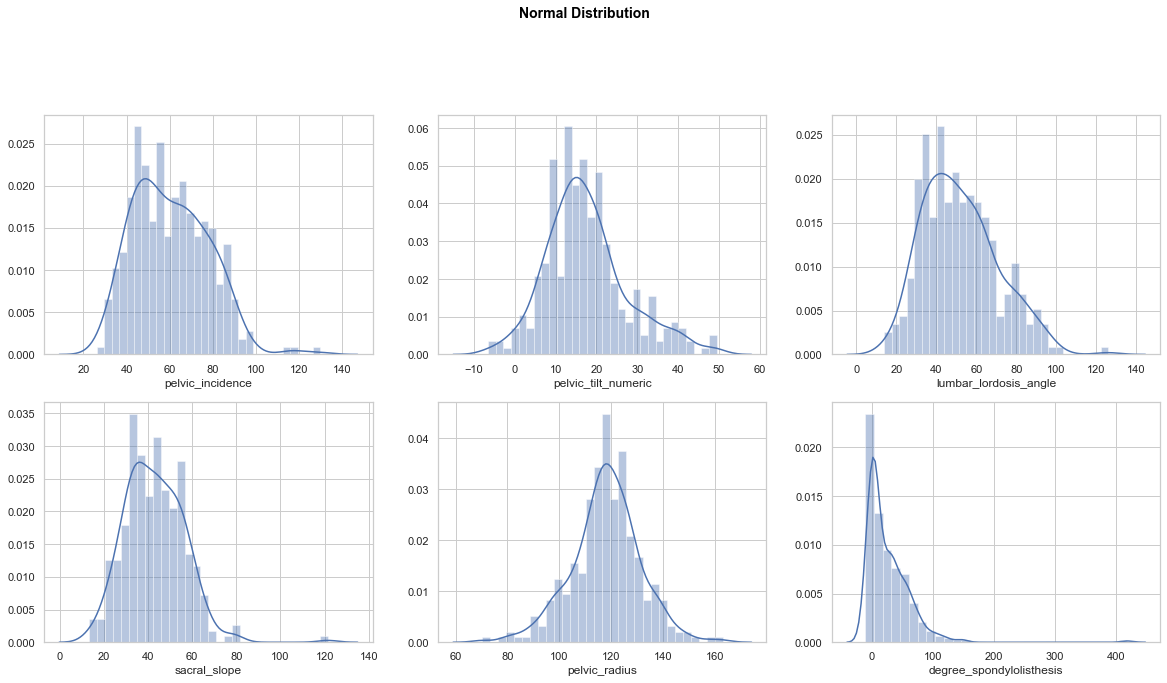

In [12]:
k=1
plt.figure(figsize=(20, 15))
for i in columns[:-1]:
    plt.subplot(3, 3, k)
    sns.distplot((df[i]), 
                 bins=30, 
                 norm_hist=True)
    k+=1
plt.suptitle('Normal Distribution',
          color='black',
          fontsize=14,
          fontweight='bold')
plt.show()

#### We can see the outlier data points and distortions according to the box plots and data distribution, especially in the last feature. Therefore, the data can affect our model in a negative way. Before we do outlier detection, we will install our model and carry out the training.

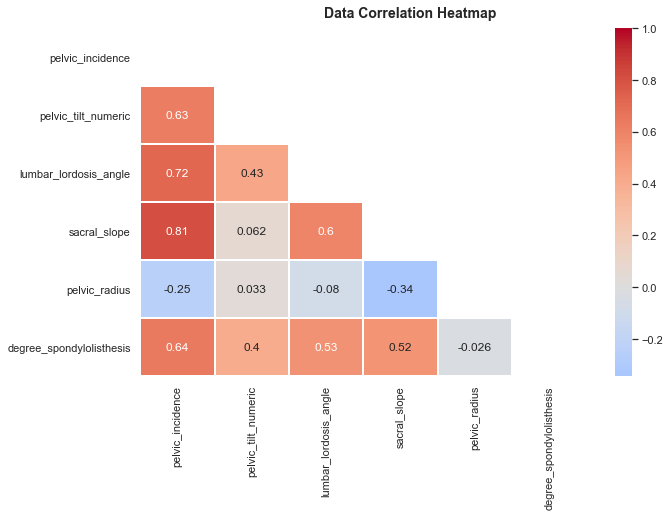

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,6))
matrix = np.triu(df.corr())
hm = sns.heatmap(df.corr(), 
                 ax=ax,           
                 cmap="coolwarm", 
                 linewidths=1,
                 annot=True,
                 center=0,
                 mask=matrix
          
                )
fig.subplots_adjust(top=0.93)
fig.suptitle('Data Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')
plt.show()

#### Since boosted trees use individual decision trees, they also are unaffected by multi-collinearity. We can evaluate the importance of every feature and maintain only the best features for your final model. In this study, I only showed good features for models

## Model

In [14]:
#Label encoder for target value
label_encoder = preprocessing.LabelEncoder()
df['class']=label_encoder.fit_transform(df['class'].values)

In [15]:
#Normalization
df.iloc[:,:-1] = preprocessing.StandardScaler().fit_transform(df.iloc[:,:-1])
#Train test
X = df.drop(['class'],axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
#AdaBoost Classifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

test_score = round(accuracy_score(y_test,y_pred) * 100, 2)
print ('The accuracy for the AdaBoost model is',test_score,"%")

conf_matrix= pd.crosstab(y_pred, y_test)
print('\n Confision matrix')
print(conf_matrix)

clf_report=classification_report(y_test , y_pred , target_names=['Abnormal','Normal'])
print('\n Classification report')
print(clf_report)

The accuracy for the AdaBoost model is 80.65 %

 Confision matrix
class   0   1
row_0        
0      60   9
1       9  15

 Classification report
              precision    recall  f1-score   support

    Abnormal       0.87      0.87      0.87        69
      Normal       0.62      0.62      0.62        24

    accuracy                           0.81        93
   macro avg       0.75      0.75      0.75        93
weighted avg       0.81      0.81      0.81        93



In [17]:
#Gradient Boosting Classifier
gdb = GradientBoostingClassifier()
gdb.fit(X_train, y_train)
y_pred = gdb.predict(X_test)

test_score = round(accuracy_score(y_test,y_pred) * 100, 2)
print ('The accuracy for the AdaBoost model is',test_score,"%")

conf_matrix= pd.crosstab(y_pred, y_test)
print('\n Confision matrix')
print(conf_matrix)

clf_report=classification_report(y_test , y_pred , target_names=['Abnormal','Normal'])
print('\n Classification report')
print(clf_report)

The accuracy for the AdaBoost model is 80.65 %

 Confision matrix
class   0   1
row_0        
0      58   7
1      11  17

 Classification report
              precision    recall  f1-score   support

    Abnormal       0.89      0.84      0.87        69
      Normal       0.61      0.71      0.65        24

    accuracy                           0.81        93
   macro avg       0.75      0.77      0.76        93
weighted avg       0.82      0.81      0.81        93



In [18]:
#XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

test_score = round(accuracy_score(y_test,y_pred) * 100, 2)
print ('The accuracy for the XGBoost model is',test_score,"%")

conf_matrix= pd.crosstab(y_pred, y_test)
print('\n Confision matrix')
print(conf_matrix)

clf_report=classification_report(y_test , y_pred , target_names=['Abnormal','Normal'])
print('\n Classification report')
print(clf_report)

The accuracy for the XGBoost model is 80.65 %

 Confision matrix
class   0   1
row_0        
0      59   8
1      10  16

 Classification report
              precision    recall  f1-score   support

    Abnormal       0.88      0.86      0.87        69
      Normal       0.62      0.67      0.64        24

    accuracy                           0.81        93
   macro avg       0.75      0.76      0.75        93
weighted avg       0.81      0.81      0.81        93



## Cross Validation

In [19]:
#Cross Validation for Boosting Classifiers
boost_array = [ada, gdb, xgb]
labels = ['Ada Boosting', 'Gradient Boosting', 'XG Boosting']
results=[[],[]]

for clf in boost_array:
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    results[0].append(round(scores.mean() * 100, 2))
    results[1].append(round(scores.std(), 3))

In [20]:
results=pd.DataFrame(np.array(results).T,columns=['Accuracy Score','Standart Deviations(+/-)'])
results.insert(loc = 0,
              column = 'Classifiers',
              value = labels)
results

,Classifiers,Accuracy Score,Standart Deviations(+/-)
0,Ada Boosting,78.39,0.176
1,Gradient Boosting,79.03,0.137
2,XG Boosting,80.65,0.118


## Feature Importance for Boosting Algortihms

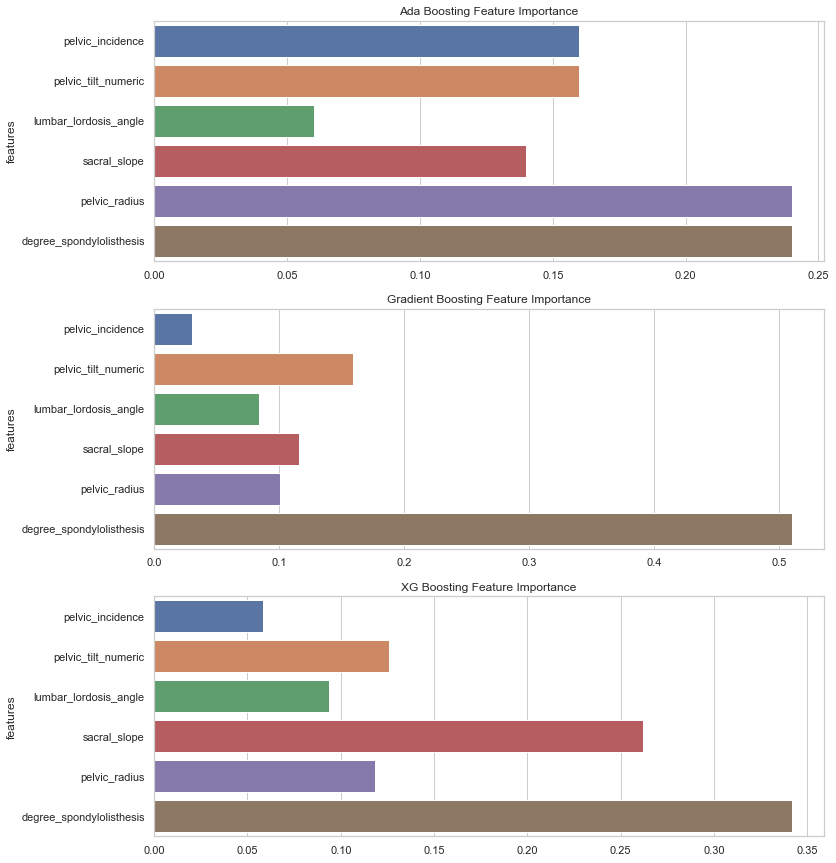

In [21]:
k=1

plt.figure(figsize=(12, 15))
for i in boost_array:
    plt.subplot(3, 1, k)
    feat_importances = pd.Series(i.feature_importances_, index=X.columns)
    sns.barplot(x=feat_importances.values, 
                y=feat_importances.index, 
                )
    
    plt.title(labels[k-1] + ' Feature Importance')
    plt.ylabel('features')
    k+=1

plt.show()

#### The most important feature for each classification is degree_spondylolisthesis.

## Outlier Detection

In [22]:
#for unique value
def unique(list_): 
    outlier = np.array(list_) 
    outlier=np.unique(outlier)
    return outlier

### Interquartile Range (IQR)

In [23]:
outlier_index=[]
for i in columns:
    if i!='class':
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        K=(df[(df[i]<(Q1-1.5*IQR)) | (df[i]>(Q3+(1.5*IQR)))].index)
        for i in K:
            outlier_index.append(i)

outlier_iqr =unique(outlier_index)

### Z Score

In [24]:
outlier_index=[]
for i in columns:
    if i!='class':
        K=df[stats.zscore(df[i])>=3].index
        for i in K:
            outlier_index.append(i)

outlier_zscore =unique(outlier_index)

### Length of outlier

In [25]:
print('Outlier count for iqr test: ',len(outlier_iqr))
print('Outlier count for z score: ',len(outlier_zscore))

Outlier count for iqr test:  31
Outlier count for z score:  11


#### The number of outliers is quite high compared to the iqr test. If the number of data we have is low, this will cause problems and may decrease the accuracy value. But for both tests, the accuracy values will be examined.


In [26]:
def outlier_accuracy(data,outlier):
    df_outlier=data
    df_outlier=df_outlier.drop(df_outlier.index[outlier])
    #Train test
    X = df_outlier.drop(['class'],axis=1)
    y = df_outlier['class']
    
    results=[[],[]]

    for clf in boost_array:
        scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        results[0].append(round(scores.mean() * 100, 2))
        results[1].append(round(scores.std(), 3))
    
    results=pd.DataFrame(np.array(results).T,columns=['Accuracy Score','Standart Deviations(+/-)'])
    results.insert(loc = 0,
                   column = 'Classifiers',
                   value = labels)
    
    return results

In [27]:
outlier_accuracy(df,outlier_iqr)

,Classifiers,Accuracy Score,Standart Deviations(+/-)
0,Ada Boosting,76.71,0.144
1,Gradient Boosting,79.23,0.148
2,XG Boosting,78.51,0.139


In [28]:
outlier_accuracy(df,outlier_zscore)

,Classifiers,Accuracy Score,Standart Deviations(+/-)
0,Ada Boosting,77.62,0.150
1,Gradient Boosting,80.63,0.149
2,XG Boosting,80.62,0.116


#### According to the results, the accuracy value for iqr test decreases, while the values ​​for z score are approximately the same.